The [new editor retention rate](https://meta.wikimedia.org/wiki/Research:Surviving_new_editor) suddenly spiked among the January 2018 cohort of new editors. Is this real or is it a bug in the data?

In [24]:
import datetime as dt

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [110]:
import wmfdata as wmf

In [274]:
# Customize Matplotlib styles
%matplotlib inline
mpl.rcParams["font.size"] = 15
mpl.rcParams["figure.figsize"] = (16, 10)
pct_ax = mpl.ticker.FuncFormatter(lambda x, pos: "{:.0%}".format(x))

# Data imports and transformation

## Monthly aggregates

In [237]:
glob_mo = pd.read_table("data/adl_global_monthly_retention.tsv")
glob_mo["reg_mo"] = pd.to_datetime(glob_mo["reg_mo"])
glob_mo.head()

,reg_mo,new_eds,ret
0,2008-01-01,152640,0.082043
1,2008-02-01,147957,0.076657
2,2008-03-01,156347,0.077878
3,2008-04-01,147367,0.073029
4,2008-05-01,143481,0.071264


In [238]:
proj_mo = pd.read_table("data/adl_project_monthly_retention.tsv")
proj_mo["reg_mo"] = pd.to_datetime(proj_mo["reg_mo"])
proj_mo.head()

,wiki,reg_mo,new_eds,ret
0,abwiki,2008-01-01,7,0.142857
1,abwiki,2008-02-01,4,0.250000
2,abwiki,2008-03-01,7,0.000000
3,abwiki,2008-04-01,5,0.200000
4,abwiki,2008-05-01,5,0.000000


In [239]:
# Filter out small wikis likely to have too much noise
proj_mo = proj_mo.groupby("wiki").filter(lambda x: x["new_eds"].mean() >= 25)
proj_mo.head()

,wiki,reg_mo,new_eds,ret
964,arwiki,2008-01-01,815,0.072393
965,arwiki,2008-02-01,854,0.052693
966,arwiki,2008-03-01,921,0.056460
967,arwiki,2008-04-01,946,0.071882
968,arwiki,2008-05-01,837,0.058542


## English Wikipedia new editors

### Revisions from MariaDB

In [174]:
en_revs = pd.read_table(
    "data/mdb_enwiki_new_editor_revisions.tsv",
    parse_dates=["reg_dt", "edit_dt"],
    dtype={
        "mob": np.bool,
        "ve": np.bool
    }
)
en_revs.head()

,user_id,rev_id,reg_dt,edit_dt,mob,ve
0,29788322,752388509,2016-12-01 00:00:15,2016-12-01 00:01:48,False,False
1,29788328,752389022,2016-12-01 00:01:09,2016-12-01 00:04:02,False,False
2,29788339,752389051,2016-12-01 00:03:08,2016-12-01 00:04:09,True,False
3,29788325,752389167,2016-12-01 00:00:34,2016-12-01 00:04:44,False,True
4,29788336,752390193,2016-12-01 00:02:26,2016-12-01 00:09:38,False,True


In [217]:
adl_en_new = pd.read_table("data/adl_enwiki_new_editors.tsv", parse_dates = ["reg_day"])
adl_en_new.head()

,user,reg_day,mo_1_revs,mo_2_revs,mo_1_reverts,mo_2_reverts
0,!!Hûm Såfår!!,2017-02-23,2,0,1,0
1,!.Jimiey.!,2016-12-17,2,0,2,0
2,!0Clarke,2018-01-06,3,0,1,0
3,!0MinutesADay,2017-11-17,1,0,0,0
4,!23455666A!wee,2017-06-29,2,0,0,0


# Exploration

In [240]:
len(adl_en_new)

626677

In [221]:
len(adl_en_new.query("(mo_1_revs == mo_1_reverts) & (mo_2_revs == mo_2_reverts)"))

169897

In [233]:
def global_retention(df):
    return (df["new_eds"] * df["ret"]).sum() / df["new_eds"].sum()

In [114]:
avg_proj_ret = proj_ret.query("cohort != '2018-01'").groupby("wiki").apply(global_retention)
avg_proj_ret = pd.DataFrame(avg_proj_ret, columns = ["avg_ret"])

avg_proj_ret.head()

,avg_ret
wiki,
arwiki,0.038981
azwiki,0.099445
bgwiki,0.037083
bnwiki,0.041036
cawiki,0.090738


In [115]:
jan_proj_ret = proj_ret.query("cohort == '2018-01'").set_index("wiki")["retention"]
jan_proj_ret = pd.DataFrame(jan_proj_ret).rename(columns = {"retention": "jan_ret"})
jan_proj_ret.head()

,jan_ret
wiki,
arwiki,0.040326
azwiki,0.105769
bgwiki,0.038251
bnwiki,0.052448
cawiki,0.033582


In [116]:
proj_ret_vs = avg_proj_ret.join(jan_proj_ret, how = "inner")
proj_ret_vs.head()

,avg_ret,jan_ret
wiki,,
arwiki,0.038981,0.040326
azwiki,0.099445,0.105769
bgwiki,0.037083,0.038251
bnwiki,0.041036,0.052448
cawiki,0.090738,0.033582


In [117]:
s = pd.DataFrame(proj_ret_vs.stack(), columns = ["retention"])
s.head()

retention
wiki                     
arwiki avg_ret   0.038981
       jan_ret   0.040326
azwiki avg_ret   0.099445
       jan_ret   0.105769
bgwiki avg_ret   0.037083

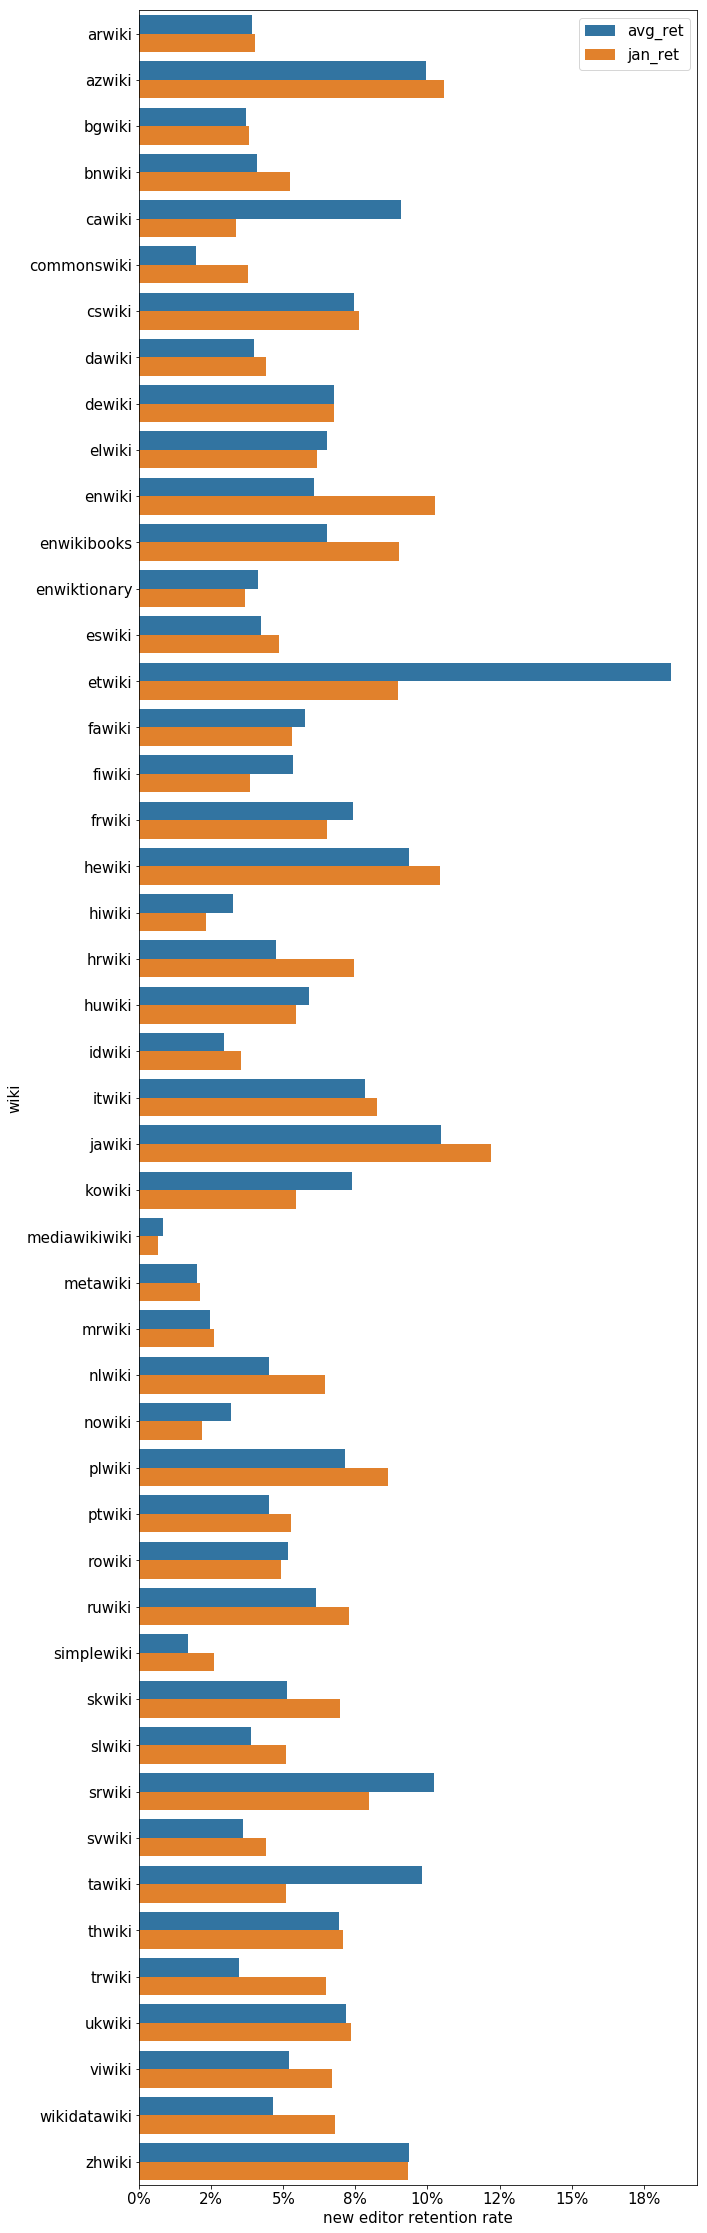

In [250]:
fig, ax = plt.subplots(figsize = (10, 40))


ax.xaxis.set_major_formatter(pct_ax)

g = sns.barplot(x = s.retention, y = s.index.get_level_values(0), hue = s.index.get_level_values(1))

ax.xaxis.set_label_text("new editor retention rate")

In [119]:
# Ten highest retention wikis on average
avg_proj_ret.sort_values("avg_ret", ascending = False).head(n = 10)

,avg_ret
wiki,
euwiki,0.362776
etwiki,0.184361
hywiki,0.165217
enwikiversity,0.162313
knwiki,0.106195
jawiki,0.104687
srwiki,0.102374
azwiki,0.099445
tawiki,0.098119


In [120]:
# Ten highest retention wikis in January
jan_proj_ret.sort_values("jan_ret", ascending = False).head(n = 10)

,jan_ret
wiki,
jawiki,0.121892
azwiki,0.105769
hewiki,0.104242
enwiki,0.102744
zhwiki,0.093240
enwikibooks,0.090090
etwiki,0.089744
plwiki,0.086285
itwiki,0.082331


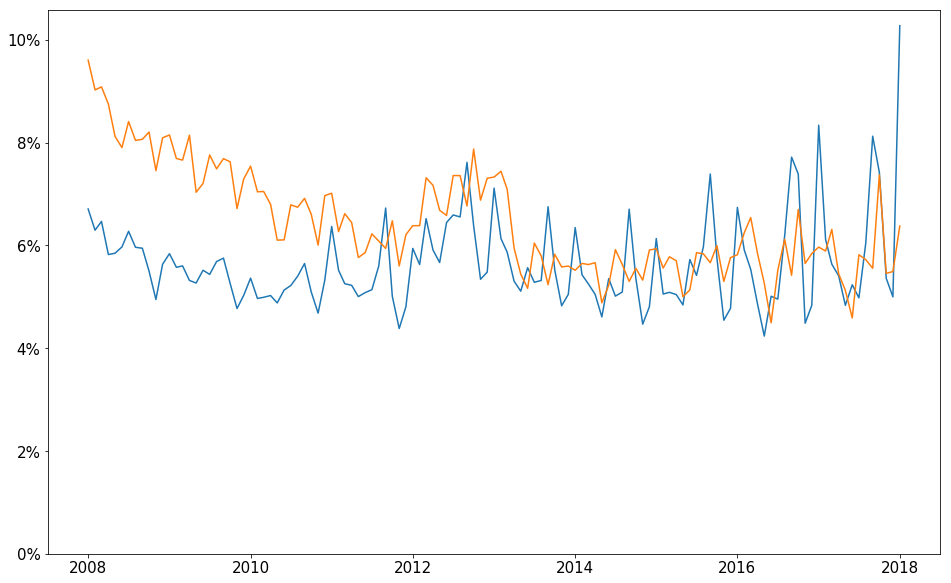

In [269]:
# Enwiki and non-enwiki retention
plt.plot(proj_mo.query("wiki == 'enwiki'").groupby("reg_mo").apply(global_retention))
plt.plot(proj_mo.query("wiki != 'enwiki'").groupby("reg_mo").apply(global_retention))
plt.gca().yaxis.set_major_formatter(pct_ax)
plt.ylim(ymin=0);

What's the relationship between the number of new editors from a day's cohort and their retention rates?

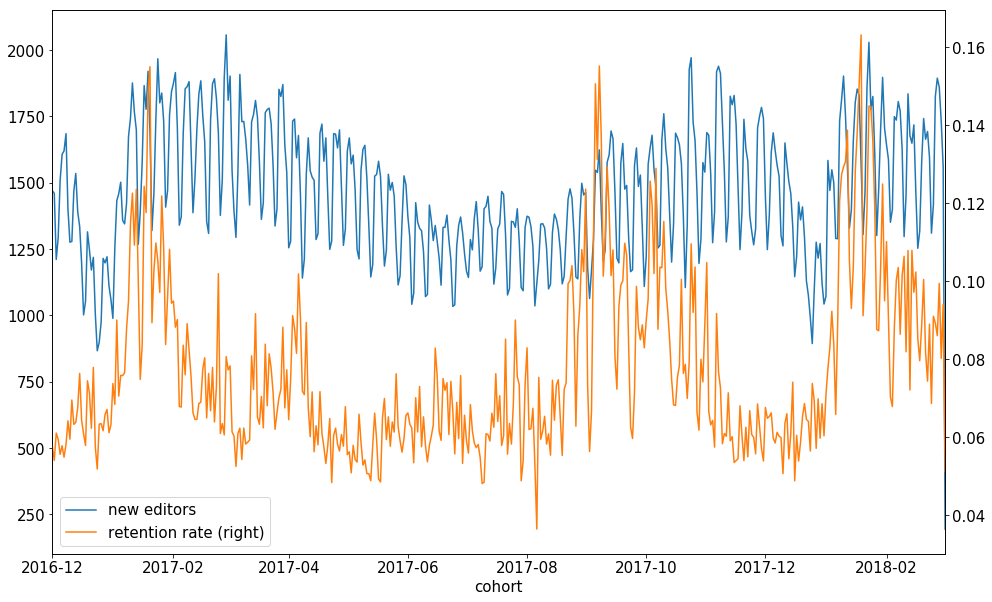

In [273]:
cohorts.first_mo.plot(label="new editors", legend=True)
cohorts.retention.plot(secondary_y=True, label="retention rate", legend=True);

## Diving into English Wikipedia

In [124]:
def ret(g):
    df = enw_new
    
    new_eds =  g["user_name"].count()
    ret_eds = g[df.ix[g.index]["2nd_month_edits"] >= 1]["user_name"].count()
    return ret_eds / new_eds

adl_new = enw_new.groupby("cohort").count()["user_name"]

adl_ret = enw_new.groupby("cohort").apply(ret)

enw_daily = pd.DataFrame({"new": adl_new, "ret": adl_ret})
enw_daily.head()

,new,ret
cohort,,
2017-11-01,1701,0.094062
2017-11-02,1690,0.059763
2017-11-03,1539,0.055231
2017-11-04,1285,0.053696
2017-11-05,1411,0.051028


In [83]:
en_revs.groupby(["mob", "ve"])["user_id"].count()

mob    ve   
False  False    5072450
       True      922333
True   False     963910
       True      106074
Name: user_id, dtype: int64

In [84]:
td_30 = dt.timedelta(days = 30)
td_60 = dt.timedelta(days = 60)

en_revs["since_reg"] = en_revs["edit_dt"] -  en_revs["reg_dt"]
en_revs["first_mo"] = en_revs["since_reg"] < td_30
en_revs["second_mo"] = (en_revs["since_reg"] >= td_30) & (en_revs["since_reg"] < td_60)

In [85]:
en_revs.sample(n = 10)

,user_id,rev_id,reg_dt,edit_dt,mob,ve,since_reg,first_mo,second_mo
290687,30020873,760400792,2017-01-03 22:30:41,2017-01-16 19:35:38,False,False,12 days 21:04:57,True,False
5743804,30055705,824067628,2017-01-08 18:24:25,2018-02-05 03:38:32,False,False,392 days 09:14:07,False,False
3560038,32042800,803037888,2017-09-30 01:47:15,2017-09-30 01:48:31,True,False,0 days 00:01:16,True,False
5735239,33012011,823993753,2018-02-04 17:59:47,2018-02-04 18:13:33,False,False,0 days 00:13:46,True,False
6873285,32266845,836640451,2017-10-29 22:03:24,2018-04-16 00:11:21,True,False,168 days 02:07:57,False,False
6227480,32769668,828205530,2018-01-03 23:39:35,2018-03-01 04:30:08,False,True,56 days 04:50:33,False,True
6503888,31885086,831082489,2017-09-08 08:45:47,2018-03-18 17:15:11,False,False,191 days 08:29:24,False,False
6032370,30268075,826540769,2017-02-04 03:11:00,2018-02-19 18:39:52,False,False,380 days 15:28:52,False,False
803826,30427614,768515376,2017-02-22 15:20:33,2017-03-04 07:47:06,False,False,9 days 16:26:33,True,False
3322347,31930634,800595402,2017-09-14 13:52:28,2017-09-14 14:26:41,False,False,0 days 00:34:13,True,False


In [86]:
en_revs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7064767 entries, 0 to 7064766
Data columns (total 9 columns):
user_id      int64
rev_id       int64
reg_dt       datetime64[ns]
edit_dt      datetime64[ns]
mob          bool
ve           bool
since_reg    timedelta64[ns]
first_mo     bool
second_mo    bool
dtypes: bool(4), datetime64[ns](2), int64(2), timedelta64[ns](1)
memory usage: 296.4 MB


In [88]:
true_prop = lambda x: (x == True).sum() / x.count()

en_new = en_revs.groupby("user_id").agg({
    "reg_dt": lambda x: dt.datetime.date(np.min(x)),
    "first_mo": np.sum,
    "second_mo": np.sum,
    "mob": true_prop,
    "ve": true_prop
})

In [153]:
en_new.sample(n = 10)

,reg_dt,first_mo,second_mo,mob,ve
user_id,,,,,
31140513,2017-05-21,2.0,0.0,0.0,0.000000
31664073,2017-08-06,2.0,0.0,0.5,0.000000
32469270,2017-11-24,8.0,0.0,0.0,0.875000
32958896,2018-01-28,7.0,8.0,0.0,0.740741
31899575,2017-09-10,9.0,0.0,0.0,0.222222
30621574,2017-03-17,1.0,0.0,1.0,0.000000
30647898,2017-03-21,2.0,0.0,1.0,1.000000
32252418,2017-10-27,7.0,0.0,0.0,0.285714
32650512,2017-12-18,1.0,0.0,0.0,0.000000


In [154]:
def eds_to_coh(eds_df):
    editors = lambda x: (x >= 1).sum()

    coh = eds_df.groupby("reg_dt").agg({
        "first_mo": editors,
        "second_mo": editors,
        "mob": np.mean,
        "ve": np.mean
    })
    
    coh["retention"] = coh["second_mo"] / coh["first_mo"]
    
    coh = coh.reindex(cohorts.index.rename("cohort"))
    coh.rename({"mob": "avg_mob", "ve": "avg_ve"})
    
    return coh

In [156]:
cohorts = eds_to_coh(en_new)
cohorts

,first_mo,second_mo,mob,ve,retention
cohort,,,,,
2016-12-01,1470.0,85.0,0.277609,0.229704,0.057823
2016-12-02,1460.0,79.0,0.264706,0.193300,0.054110
2016-12-03,1211.0,74.0,0.362672,0.178558,0.061107
2016-12-04,1293.0,77.0,0.331249,0.189448,0.059551
2016-12-05,1509.0,84.0,0.280065,0.187504,0.055666
2016-12-06,1607.0,93.0,0.288474,0.200203,0.057872
2016-12-07,1620.0,89.0,0.237067,0.199599,0.054938
2016-12-08,1685.0,98.0,0.236187,0.232266,0.058160
2016-12-09,1401.0,90.0,0.284411,0.205531,0.064240


In [160]:
r_cohorts = cohorts.rolling(7).mean()

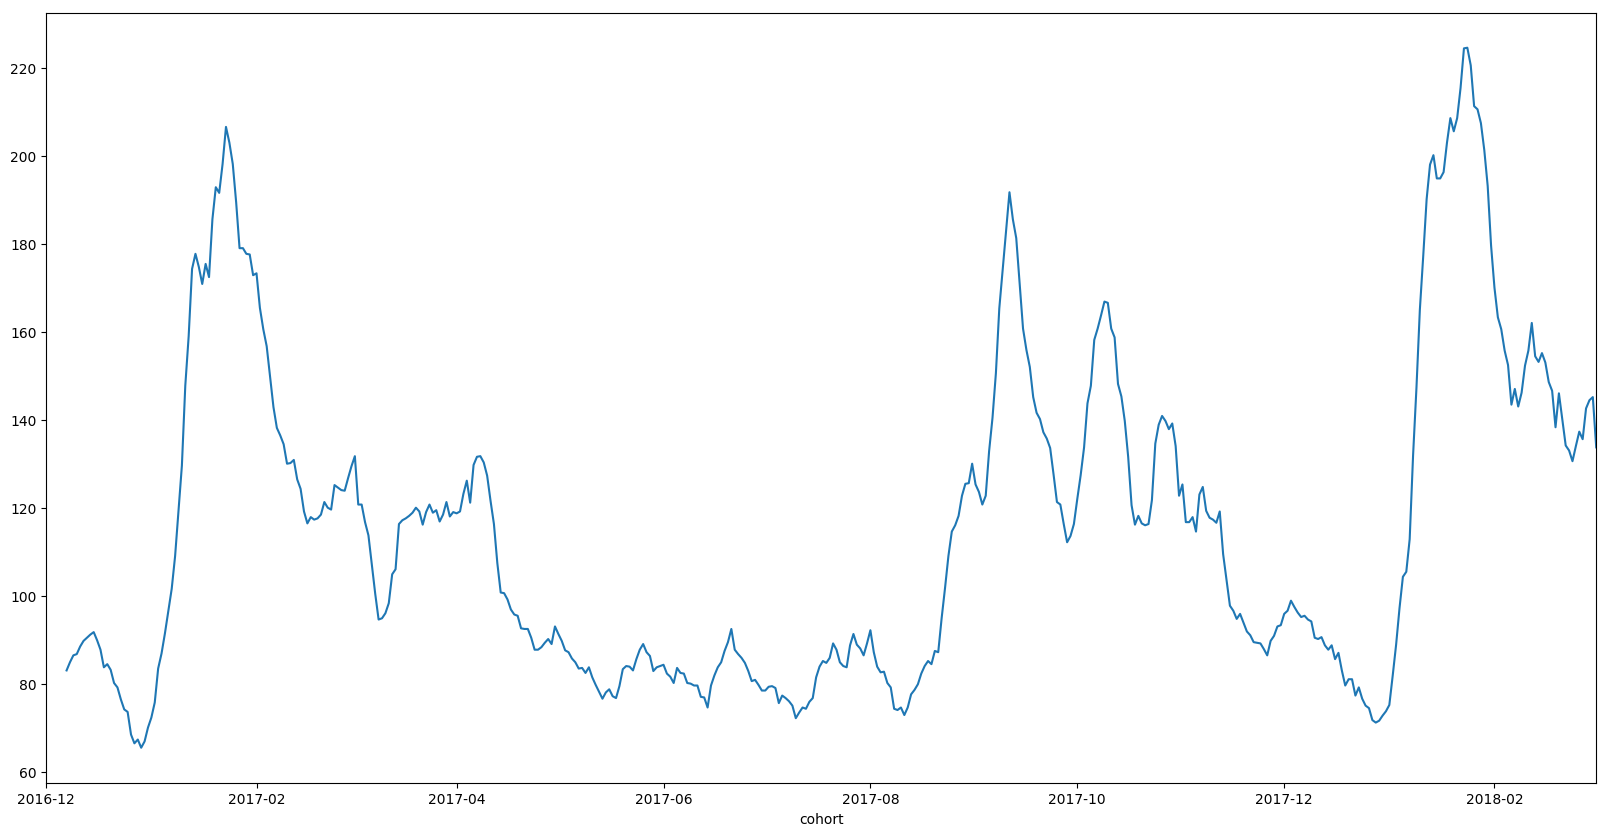

In [161]:
r_cohorts["second_mo"].plot()

In [ ]:
pd.merge(pd.DataFrame(adl_ret), pd.DataFrame(mdb_ret), left_index = True, right_index = True)

In [ ]:
pd.DataFrame(adl_ret).join(pd.DataFrame(mdb_ret))

In [ ]:
pd.DataFrame(adl_ret).index

In [150]:
cohorts.retention.plot()
cohorts.second_mo.plot(secondary_y=True, label="retained new eds", legend=True)

AttributeError: 'DataFrame' object has no attribute 'retention'

In [66]:
cohorts.sort_values("retention", ascending = False)

,first_mo,second_mo,retention
cohort,,,
2018-01-19,1563.0,255.0,0.163148
2018-01-18,1829.0,277.0,0.151449
2018-01-24,1775.0,258.0,0.145352
2018-01-23,2029.0,294.0,0.144899
2018-01-12,1557.0,216.0,0.138728
2018-01-17,1854.0,256.0,0.138080
2018-01-25,1825.0,249.0,0.136438
2018-01-11,1753.0,229.0,0.130633
2018-01-10,1902.0,246.0,0.129338
